In [2]:
import pandas as pd
import numpy as np
import zipfile
import os
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Function to upload and extract zip files in Colab
from google.colab import files
import io

def upload_and_extract_zip():
    uploaded = files.upload()  # This will prompt you to upload the zip file
    for filename in uploaded.keys():
        with zipfile.ZipFile(io.BytesIO(uploaded[filename]), 'r') as z:
            z.extractall()  # Extracts to the current working directory
            print(f'Extracted contents of {filename} to the current working directory')
            return z.namelist()[0]  # Assuming there's one main CSV file in the zip

# Step 2: Load data
csv_file_name = upload_and_extract_zip()  # The function now handles upload and extraction
meds = pd.read_csv(csv_file_name)  # Load the extracted CSV file
meds.head(5)


Saving Medicine_Details.csv.zip to Medicine_Details.csv.zip
Extracted contents of Medicine_Details.csv.zip to the current working directory


,Medicine Name,Composition,Uses,Side_effects,Image URL,Manufacturer,Excellent Review %,Average Review %,Poor Review %
0,Avastin 400mg Injection,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lun...,Rectal bleeding Taste change Headache Noseblee...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Roche Products India Pvt Ltd,22,56,22
1,Augmentin 625 Duo Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glaxo SmithKline Pharmaceuticals Ltd,47,35,18
2,Azithral 500 Tablet,Azithromycin (500mg),Treatment of Bacterial infections,Nausea Abdominal pain Diarrhea,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Alembic Pharmaceuticals Ltd,39,40,21
3,Ascoril LS Syrup,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...,Treatment of Cough with mucus,Nausea Vomiting Diarrhea Upset stomach Stomach...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glenmark Pharmaceuticals Ltd,24,41,35
4,Aciloc 150 Tablet,Ranitidine (150mg),Treatment of Gastroesophageal reflux disease (...,Headache Diarrhea Gastrointestinal disturbance,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Cadila Pharmaceuticals Ltd,34,37,29


<ipython-input-5-bb47e708effc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds.drop_duplicates(inplace=True)
<ipython-input-5-bb47e708effc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds['Composition'] = meds['Composition'].apply(clean_composition)
<ipython-input-5-bb47e708effc>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

10         Azee 500 Tablet
41       Azicip 500 Tablet
75         Azax 500 Tablet
114    Azikem 500mg Tablet
146      Aziwok 500 Tablet
159     Azibact 500 Tablet
165         ATM 500 Tablet
204     Azilide 500 Tablet
313      Azimax 500 Tablet
347     Azifast 500 Tablet
Name: Medicine Name, dtype: object


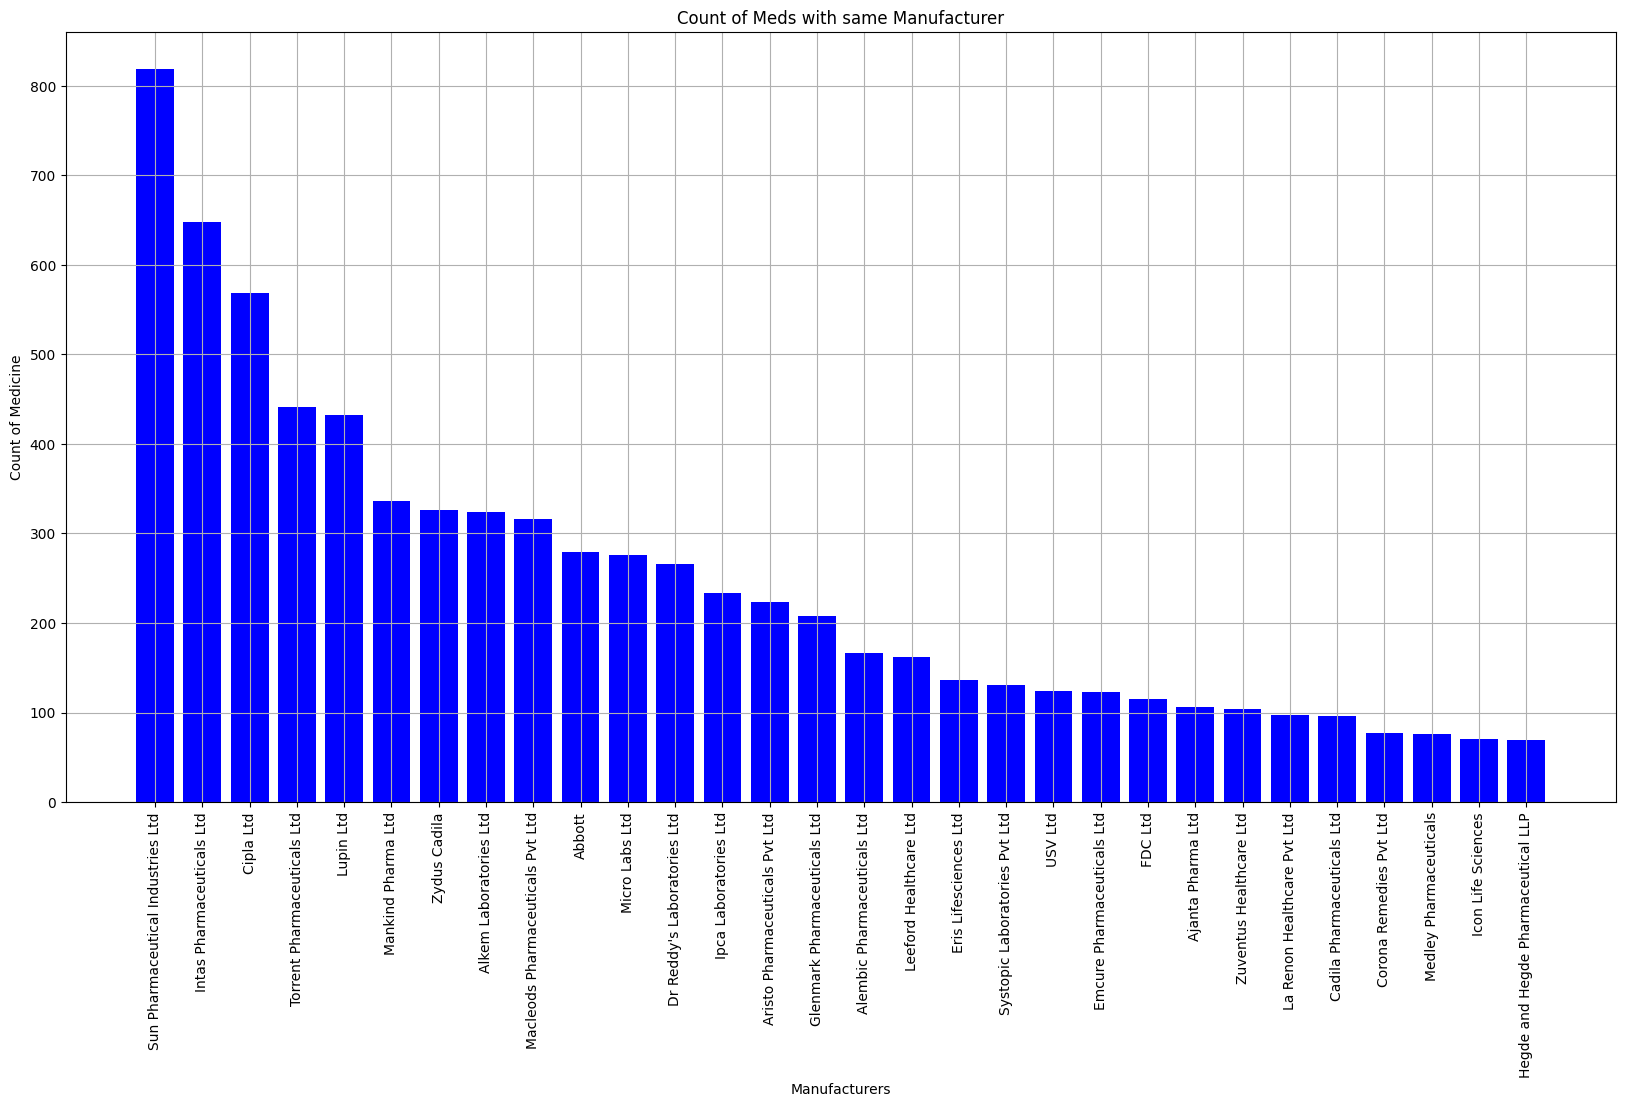

In [5]:
# Select relevant columns
meds = meds[['Medicine Name', 'Composition', 'Uses', 'Image URL', 'Manufacturer', 'Excellent Review %', 'Average Review %', 'Poor Review %']]

# Remove duplicates
meds.drop_duplicates(inplace=True)

# Data cleaning functions
def clean_composition(comp):
    return [item.strip().replace(" ", "") for item in comp.split('+')]

def clean_uses(uses):
    return uses.split()

# Apply cleaning functions
meds['Composition'] = meds['Composition'].apply(clean_composition)
meds['Uses'] = meds['Uses'].apply(clean_uses)

# Calculate medicine score
meds['Medicine Score'] = round((meds['Excellent Review %']/100 * 5) + (meds['Average Review %']/100 * 3) + (meds['Poor Review %']/100 * 1), 2)

# Creating tags for content-based filtering
meds['tags'] = meds['Composition'] + meds['Uses']
meds['tags'] = meds['tags'].apply(lambda x: ' '.join(x)).str.lower()

# Stemming the tags
stemmer = PorterStemmer()
meds['tags'] = meds['tags'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Vectorization of tags
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
vector = vectorizer.fit_transform(meds['tags'])

# Compute cosine similarity matrix
similarity = cosine_similarity(vector)

# Function to recommend medicines based on the medicine name
def recommend(medicine_name, meds, similarity):
    indices = pd.Series(meds.index, index=meds['Medicine Name']).drop_duplicates()
    idx = indices[medicine_name]

    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores[1:11]]  # top 10 recommendations

    return meds['Medicine Name'].iloc[top_indices]


# Example usage
recommended_meds = recommend('Azithral 500 Tablet', meds, similarity)
print(recommended_meds)

# Plotting function for visualization
def plot_data(x, y, title, xlabel, ylabel, kind='bar', rotation=90):
    plt.figure(figsize=(20, 10))
    if kind == 'bar':
        plt.bar(x, y, color='b')
    plt.grid(True)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Example plot
plot_data(meds['Manufacturer'].value_counts().keys()[:30], meds['Manufacturer'].value_counts()[:30], 'Count of Meds with same Manufacturer', 'Manufacturers', 'Count of Medicine')


In [6]:
def recommend_based_on_disease(disease, meds, similarity, top_n=10):
    # Convert the input disease to lower case to handle case insensitivity
    disease = disease.lower()

    # Create a filtered DataFrame where the disease is mentioned in the 'Uses'
    filtered_meds = meds[meds['Uses'].apply(lambda x: any(disease in use.lower() for use in x))]

    if filtered_meds.empty:
        return pd.DataFrame([], columns=['Medicine Name', 'Uses', 'Composition', 'Medicine Score'])

    indices = pd.Series(filtered_meds.index, index=filtered_meds['Medicine Name']).drop_duplicates()

    # Compute cosine similarity within the filtered DataFrame
    vectorizer = TfidfVectorizer(stop_words='english')
    uses_tfidf = vectorizer.fit_transform(filtered_meds['Uses'].apply(lambda x: ' '.join(x)))
    local_similarity = cosine_similarity(uses_tfidf)

    # Aggregate scores and recommend top N medicines
    scores = []
    for idx, _ in enumerate(filtered_meds['Medicine Name']):
        scores.extend([(other_idx, sim) for other_idx, sim in enumerate(local_similarity[idx]) if idx != other_idx])

    # Sort scores by similarity
    scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)
    top_indices = [score[0] for score in scores_sorted[:top_n]]

    recommended_meds = filtered_meds.iloc[top_indices][['Medicine Name', 'Uses', 'Composition', 'Medicine Score']]
    return recommended_meds

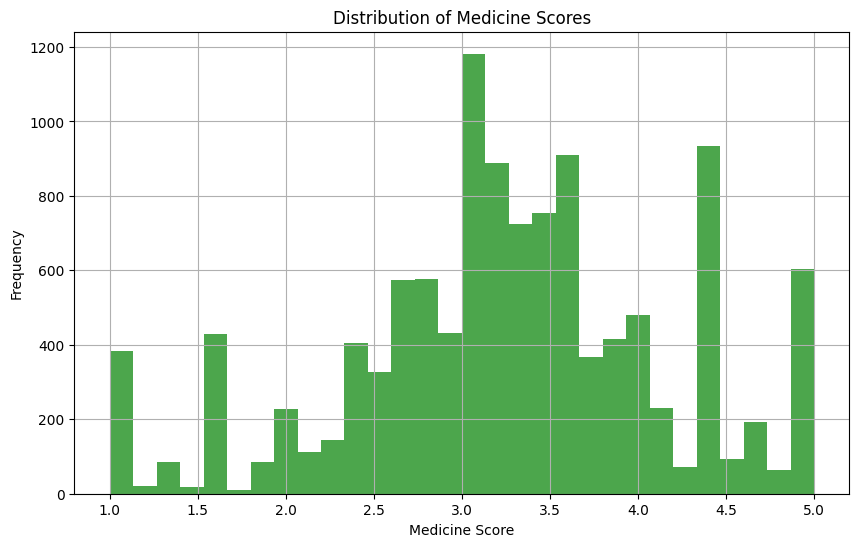

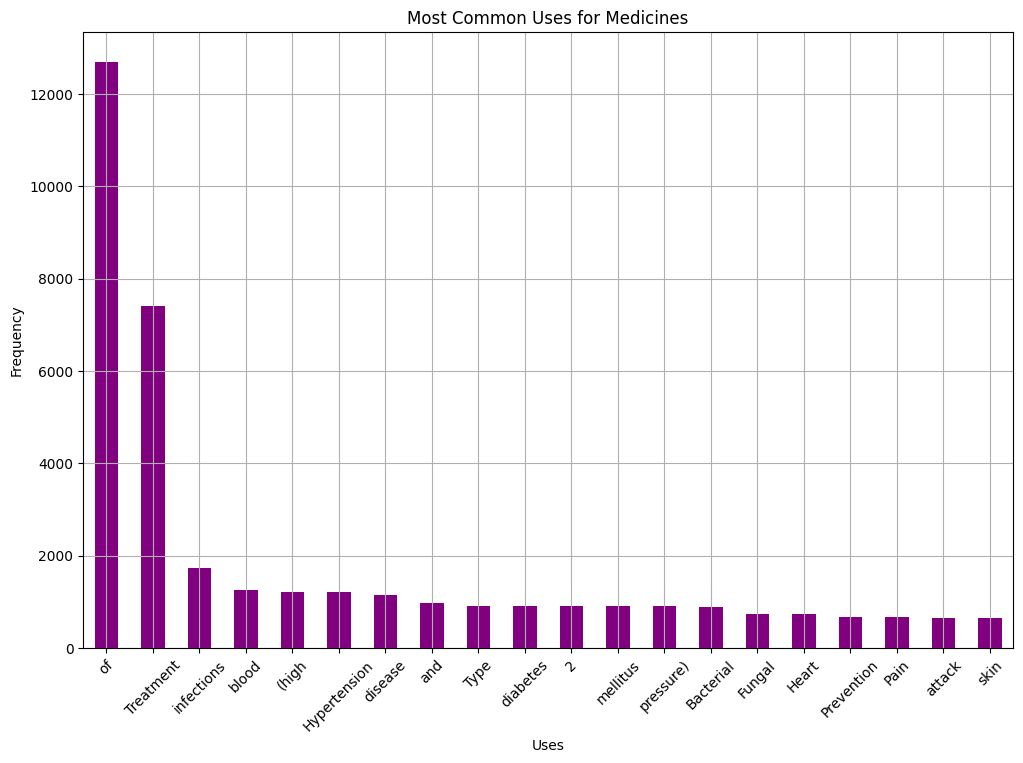

In [7]:
# Visualizing the distribution of medicine scores
def plot_medicine_score_distribution(meds):
    plt.figure(figsize=(10, 6))
    plt.hist(meds['Medicine Score'], bins=30, color='green', alpha=0.7)
    plt.title('Distribution of Medicine Scores')
    plt.xlabel('Medicine Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_medicine_score_distribution(meds)

# Visualizing the most common uses
def plot_common_uses(meds):
    uses = pd.Series([use for sublist in meds['Uses'] for use in sublist])
    common_uses = uses.value_counts().head(20)
    plt.figure(figsize=(12, 8))
    common_uses.plot(kind='bar', color='purple')
    plt.title('Most Common Uses for Medicines')
    plt.xlabel('Uses')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

plot_common_uses(meds)


In [8]:
# Adjust user interaction to ask for a disease
def user_interaction():
    print("Welcome to the Medicine Recommendation System")
    while True:
        print("\nEnter a disease name to get recommendations or type 'exit' to quit:")
        input_disease = input().strip()
        if input_disease.lower() == 'exit':
            print("Exiting the system.")
            break
        recommendations = recommend_based_on_disease(input_disease, meds, similarity, top_n=5)
        if recommendations.empty:
            print("No recommendations found. Please check the disease name and try again.")
        else:
            print("\nRecommended Medicines:")
            print(recommendations.to_string(index=False))

In [10]:
user_interaction()

Welcome to the Medicine Recommendation System

Enter a disease name to get recommendations or type 'exit' to quit:
fever

Recommended Medicines:
       Medicine Name                               Uses          Composition  Medicine Score
   Algina 650 Tablet [Pain, reliefTreatment, of, Fever] [Paracetamol(650mg)]            4.12
Albimol 650mg Tablet [Pain, reliefTreatment, of, Fever] [Paracetamol(650mg)]            1.66
   Brufen 400 Tablet [Pain, reliefTreatment, of, Fever]   [Ibuprofen(400mg)]            3.14
   Brufen 200 Tablet [Pain, reliefTreatment, of, Fever]   [Ibuprofen(200mg)]            3.30
   Brufen 600 Tablet [Pain, reliefTreatment, of, Fever]   [Ibuprofen(600mg)]            3.10

Enter a disease name to get recommendations or type 'exit' to quit:
exit
Exiting the system.


In [11]:
# Run these in your Jupyter notebook cell
!pip install spacy
!pip install tensorflow
!python -m spacy download en_core_web_sm  # smaller model for less resource consumption


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [26]:
import tensorflow_hub as hub
import tensorflow as tf

# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def get_embeddings(texts):
    """Converts a list of texts to embeddings."""
    embeddings = embed(texts)
    return embeddings.numpy()  # Convert TensorFlow tensors to numpy arrays for easier handling



In [28]:
import pandas as pd
import tensorflow_hub as hub

# Sample data
data = {
    'Medicine Name': ['Med A', 'Med B', 'Med C'],
    'Uses': ['treats cold', 'cures fever', 'alleviates headache'],
    'Composition': ['Comp A', 'Comp B', 'Comp C'],
    'Medicine Score': [4.5, 4.0, 4.8]
}
meds = pd.DataFrame(data)

# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to get embeddings
def get_embeddings(texts):
    return embed(texts).numpy()

# Generate embeddings for the 'Uses' column
embeddings = get_embeddings(meds['Uses'].tolist())

# Assign the embeddings to the DataFrame
# Convert each embedding to a list to handle the storage in DataFrame cells properly
meds['Embeddings'] = list(map(lambda emb: emb.tolist(), embeddings))

# Now each cell under 'Embeddings' contains a list representing the embedding
print(meds.head())


  Medicine Name                 Uses Composition  Medicine Score  \
0         Med A          treats cold      Comp A             4.5   
1         Med B          cures fever      Comp B             4.0   
2         Med C  alleviates headache      Comp C             4.8   

                                          Embeddings  
0  [-0.03978883475065231, -0.026770146563649178, ...  
1  [-0.00820325966924429, -0.0029774873983114958,...  
2  [0.015597837045788765, 0.003590987529605627, 0...  


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_medicines(query, meds, top_n=5):
    """ Recommends top N similar medicines based on the query.

    Args:
    query (str): The use description to query.
    meds (DataFrame): The DataFrame containing medicine data and embeddings.
    top_n (int): The number of top similar items to return.

    Returns:
    DataFrame: The top N similar medicines.
    """
    # Generate embedding for the query
    query_embedding = get_embeddings([query])[0]

    # Extract embeddings from the DataFrame and calculate similarities
    meds_embeddings = np.array(meds['Embeddings'].tolist())
    similarities = cosine_similarity([query_embedding], meds_embeddings).flatten()

    # Get the indices of the top N similar entries
    top_indices = np.argsort(similarities)[-top_n:][::-1]

    # Return the top N similar medicines
    return meds.iloc[top_indices]

# Example query
query = "fever relief"
recommended_meds = recommend_medicines(query, meds)
print(recommended_meds[['Medicine Name', 'Uses', 'Medicine Score']])


  Medicine Name                 Uses  Medicine Score
1         Med B          cures fever             4.0
2         Med C  alleviates headache             4.8
0         Med A          treats cold             4.5


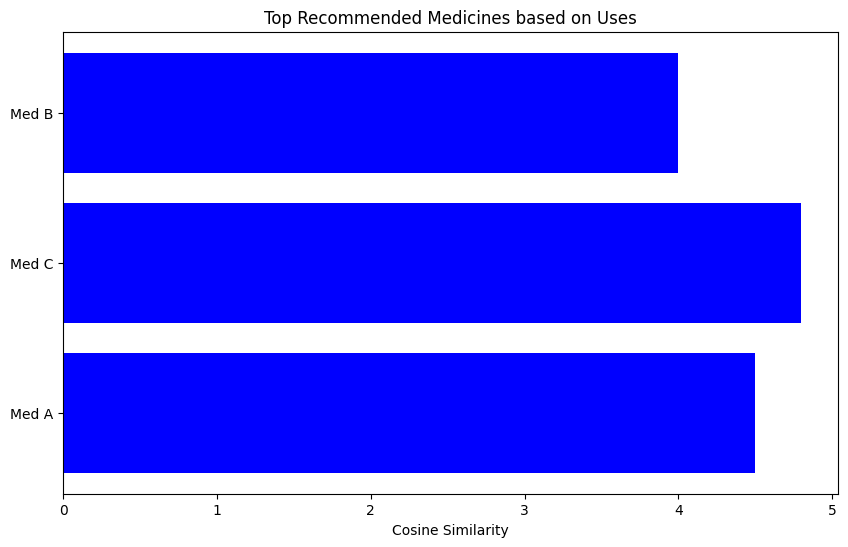

In [30]:
import matplotlib.pyplot as plt

def plot_similarities(recommended_meds):
    """ Plots the similarities of the recommended medicines.

    Args:
    recommended_meds (DataFrame): DataFrame of recommended medicines including similarity scores.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(recommended_meds['Medicine Name'], recommended_meds['Medicine Score'], color='blue')
    plt.xlabel('Cosine Similarity')
    plt.title('Top Recommended Medicines based on Uses')
    plt.gca().invert_yaxis()  # Invert axis to have the highest score on top
    plt.show()

# Plot similarities for the recommended medicines
plot_similarities(recommended_meds)


In [31]:
def filter_medicines(composition=None, min_score=None, recommended_meds=pd.DataFrame()):
    """
    Filters recommended medicines based on composition and minimum score.

    Args:
    composition (str): Specific composition to filter by.
    min_score (float): Minimum medicine score to filter by.
    recommended_meds (DataFrame): DataFrame of recommended medicines.

    Returns:
    DataFrame: Filtered DataFrame of medicines.
    """
    if composition:
        recommended_meds = recommended_meds[recommended_meds['Composition'].str.contains(composition, case=False)]
    if min_score:
        recommended_meds = recommended_meds[recommended_meds['Medicine Score'] >= min_score]
    return recommended_meds


In [32]:
def advanced_recommendations(query, composition=None, min_score=None):
    recommended_meds = recommend_medicines(query, meds)
    filtered_meds = filter_medicines(composition, min_score, recommended_meds)
    return filtered_meds

# Test the advanced recommendations function
query = "headache"
composition_filter = "Comp B"
min_score_filter = 4.0
advanced_recs = advanced_recommendations(query, composition_filter, min_score_filter)
print(advanced_recs[['Medicine Name', 'Uses', 'Composition', 'Medicine Score']])


  Medicine Name         Uses Composition  Medicine Score
1         Med B  cures fever      Comp B             4.0


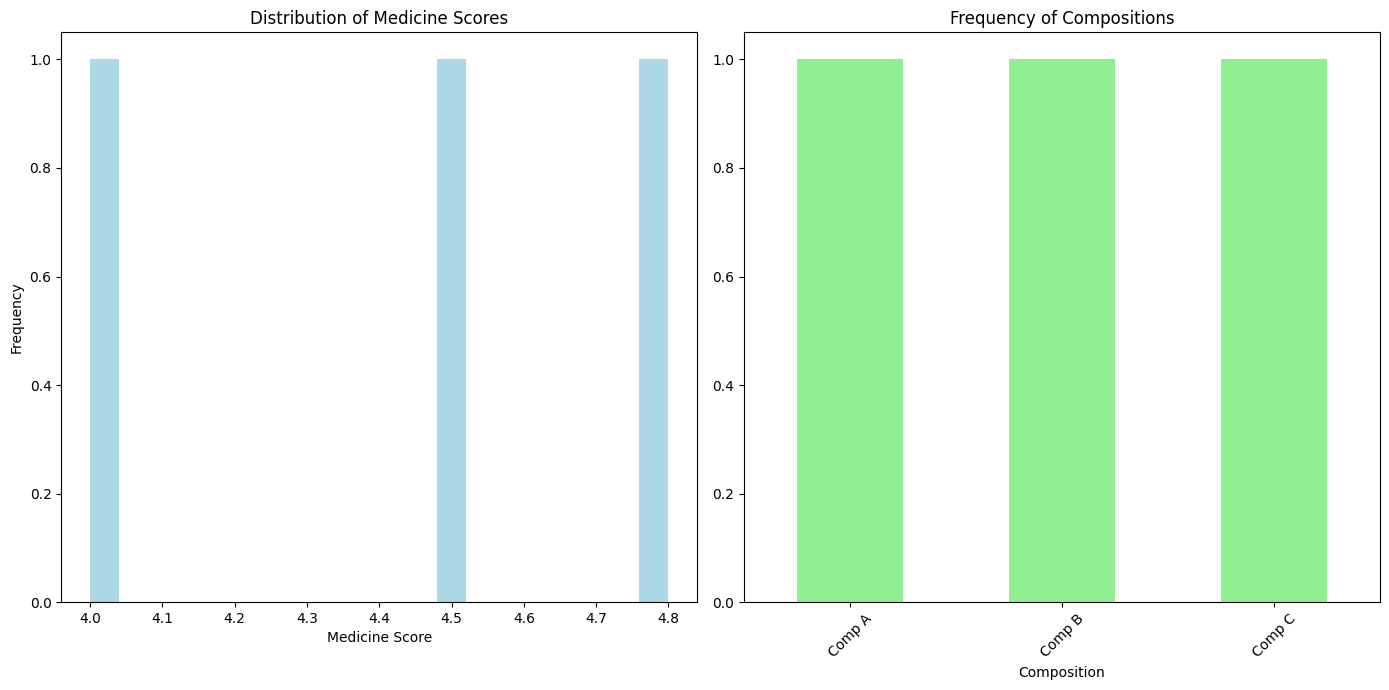

In [33]:
def visualize_medicine_data(meds):
    """
    Visualizes the distribution of medicine scores and compositions.

    Args:
    meds (DataFrame): The DataFrame containing the medicine data.
    """
    plt.figure(figsize=(14, 7))

    # Histogram of Medicine Scores
    plt.subplot(1, 2, 1)
    meds['Medicine Score'].plot(kind='hist', bins=20, color='lightblue')
    plt.title('Distribution of Medicine Scores')
    plt.xlabel('Medicine Score')

    # Bar Chart of Composition Frequencies
    plt.subplot(1, 2, 2)
    meds['Composition'].value_counts().plot(kind='bar', color='lightgreen')
    plt.title('Frequency of Compositions')
    plt.xlabel('Composition')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Call the function to visualize the data
visualize_medicine_data(meds)


In [34]:
!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:00


In [43]:
import ipywidgets as widgets
from IPython.display import display

# Label for the query input
query_label = widgets.Label('Enter your symptom or condition to find suitable medicines (e.g., "headache relief").')

# Label for the composition dropdown
composition_label = widgets.Label('Choose a specific composition to narrow down the results, or select "None" to include all compositions.')

# Label for the minimum score slider
score_label = widgets.Label('Set the minimum medicine score threshold to filter results by their quality or effectiveness. Higher scores represent higher quality.')

# Label for the submit button
submit_label = widgets.Label('Click the button to get recommendations based on your inputs.')

# Organizing widgets with labels
display(query_label, query_input)
display(composition_label, composition_input)
display(score_label, score_input)
display(submit_label, submit_button)


Text(value='headache', description='Query:', placeholder='Type your query here, e.g., "headache relief"')

Dropdown(description='Composition:', options=('None', 'Comp A', 'Comp B', 'Comp C'), value='None')

FloatSlider(value=4.2, continuous_update=False, description='Min Score:', max=5.0, readout_format='.1f')

Button(description='Recommend Medicines', icon='check', style=ButtonStyle(), tooltip='Click to get recommendat…

Recommended Medicines:


,Medicine Name,Uses,Composition,Medicine Score,Embeddings
2,Med C,alleviates headache,Comp C,4.8,"[0.015597837045788765, 0.003590987529605627, 0..."
0,Med A,treats cold,Comp A,4.5,"[-0.03978883475065231, -0.026770146563649178, ..."
